In [1]:
!pip3 install transformers
!pip3 install scikit-multilearn
!pip3 install iterative-stratification


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 9.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!apt-get install -y --no-install-recommends libcudnn8
!apt-mark hold libcudnn8

!nvcc --version
!echo "cudnn version:"
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
E: Held packages were changed and -y was used without --allow-change-held-packages.
libcudnn8 was already set on hold.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
cudnn version:
cat: /usr/local/cuda/include/cudnn_version.h: No such file or directory


In [3]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'



In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Load the dataset
df = pd.read_csv("./data_balanced.csv")
df = df.drop(columns=['None', 'powerlabel'])
df.dropna(inplace=True)

# Convert labels to tensor
labels = df.iloc[:, 1:].values

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)

# Tokenize input sentences and create attention masks
input_ids = []
attention_masks = []

for sentence in df['Content']:
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=387, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='tf')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert input_ids and attention_masks to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

# Prepare data for train-test split
X = np.hstack([input_ids.numpy(), attention_masks.numpy()])
y = labels

# Split the data into training and testing sets
train_X, test_X, train_y, test_y, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

train_input_ids, train_attention_masks = train_X[:, :387], train_X[:, 387:]
test_input_ids, test_attention_masks = test_X[:, :387], test_X[:, 387:]
train_labels, test_labels = train_y, test_y

# Define the path to save the model
model_path = "./trained_model"

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)

# Check if a saved model exists and load it, if it does
if os.path.exists(model_path):
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
else:
    # Initialize the model
    model = TFAutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=labels.shape[1])

    # Compile the model for training
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    history = model.fit(
        [train_input_ids, train_attention_masks],
        train_labels,
        epochs=4,
        batch_size=16,
        validation_data=(
            [test_input_ids, test_attention_masks],
            test_labels
        ),
        callbacks=[model_checkpoint]
    )


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1993/1993 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8691

1993/1993 [==============================] - 3007s 1s/step - loss: 0.3151 - accuracy: 0.8691 - val_loss: 0.1538 - val_accuracy: 0.9552
Epoch 2/4
1993/1993 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9628

1993/1993 [==============================] - 2965s 1s/step - loss: 0.1218 - accuracy: 0.9628 - val_loss: 0.1040 - val_accuracy: 0.9657
Epoch 3/4
1993/1993 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9748

1993/1993 [==============================] - 2927s 1s/step - loss: 0.0813 - accuracy: 0.9748 - val_loss: 0.0868 - val_accuracy: 0.9726
Epoch 4/4
1993/1993 [==============================] - 2923s 1s/step - loss: 0.0595 - accuracy: 0.9813 - val_loss: 0.0949 - val_accuracy: 0.9724


In [6]:
# Evaluate the model on the test set
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits  # Access the logits from the output object
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels


250/250 [==============================] - 228s 899ms/step


In [21]:
model.save_pretrained(model_path)
import tensorflow as tf
from transformers import TFBertForSequenceClassification

# Check if a saved model exists and load it
model_path = "./trained_model"

if os.path.exists(model_path):
    model = TFBertForSequenceClassification.from_pretrained(model_path)
else:
    print("Model not found. Please train the model and save it first.")

# Compile the loaded model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Convert test_input_ids and test_attention_masks to tensors
test_input_ids = tf.convert_to_tensor(test_input_ids)
test_attention_masks = tf.convert_to_tensor(test_attention_masks)

# Evaluate the model on the test data
evaluation_results = model.evaluate([test_input_ids, test_attention_masks], test_labels, batch_size=16)
print("Test loss: ", evaluation_results[0])
print("Test accuracy: ", evaluation_results[1])


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at ./trained_model were not used when initializing TFBertForSequenceClassification: ['roberta', 'classifier/out_proj/kernel:0', 'classifier/dense/bias:0', 'classifier/dense/kernel:0', 'classifier/out_proj/bias:0']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./

499/499 [==============================] - 245s 467ms/step - loss: 0.6871 - accuracy: 0.7201
Test loss:  0.6871362924575806
Test accuracy:  0.7201477289199829


In [7]:
# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a table
print("Classification report:")
print(report_df)


Classification report:
              precision    recall  f1-score  support
symptom_1      0.957971  0.989027  0.973252   2005.0
symptom_2      0.982199  0.987888  0.985035   1899.0
symptom_3      0.973770  0.950617  0.962055   2187.0
symptom_4      0.955017  0.828276  0.887143   2999.0
symptom_5      0.948262  0.904104  0.925657   2534.0
symptom_6      0.991180  0.966147  0.978503   1861.0
symptom_7      0.977044  0.960960  0.968935   2126.0
micro avg      0.967879  0.932291  0.949752  15611.0
macro avg      0.969349  0.941003  0.954369  15611.0
weighted avg   0.967545  0.932291  0.948887  15611.0
samples avg    0.548567  0.548385  0.546922  15611.0


In [8]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, jaccard_score

# Micro-averaged precision, recall, and F1 score
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
print("Micro-averaged Precision:", micro_precision)
print("Micro-averaged Recall:", micro_recall)
print("Micro-averaged F1 score:", micro_f1)

# Macro-averaged precision, recall, and F1 score
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 score:", macro_f1)

# Hamming Loss
hamming = hamming_loss(true_labels, predicted_labels)
print("Hamming Loss:", hamming)

# Jaccard Score
jaccard = jaccard_score(true_labels, predicted_labels, average='samples')
print("Jaccard Score:", jaccard)


Micro-averaged Precision: 0.9678792312296336
Micro-averaged Recall: 0.9322913330343988
Micro-averaged F1 score: 0.9497520229705038
Macro-averaged Precision: 0.9693490770407784
Macro-averaged Recall: 0.9410028762752558
Macro-averaged F1 score: 0.9543685238085834
Hamming Loss: 0.027606977036014557
Jaccard Score: 0.5437988873551679


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


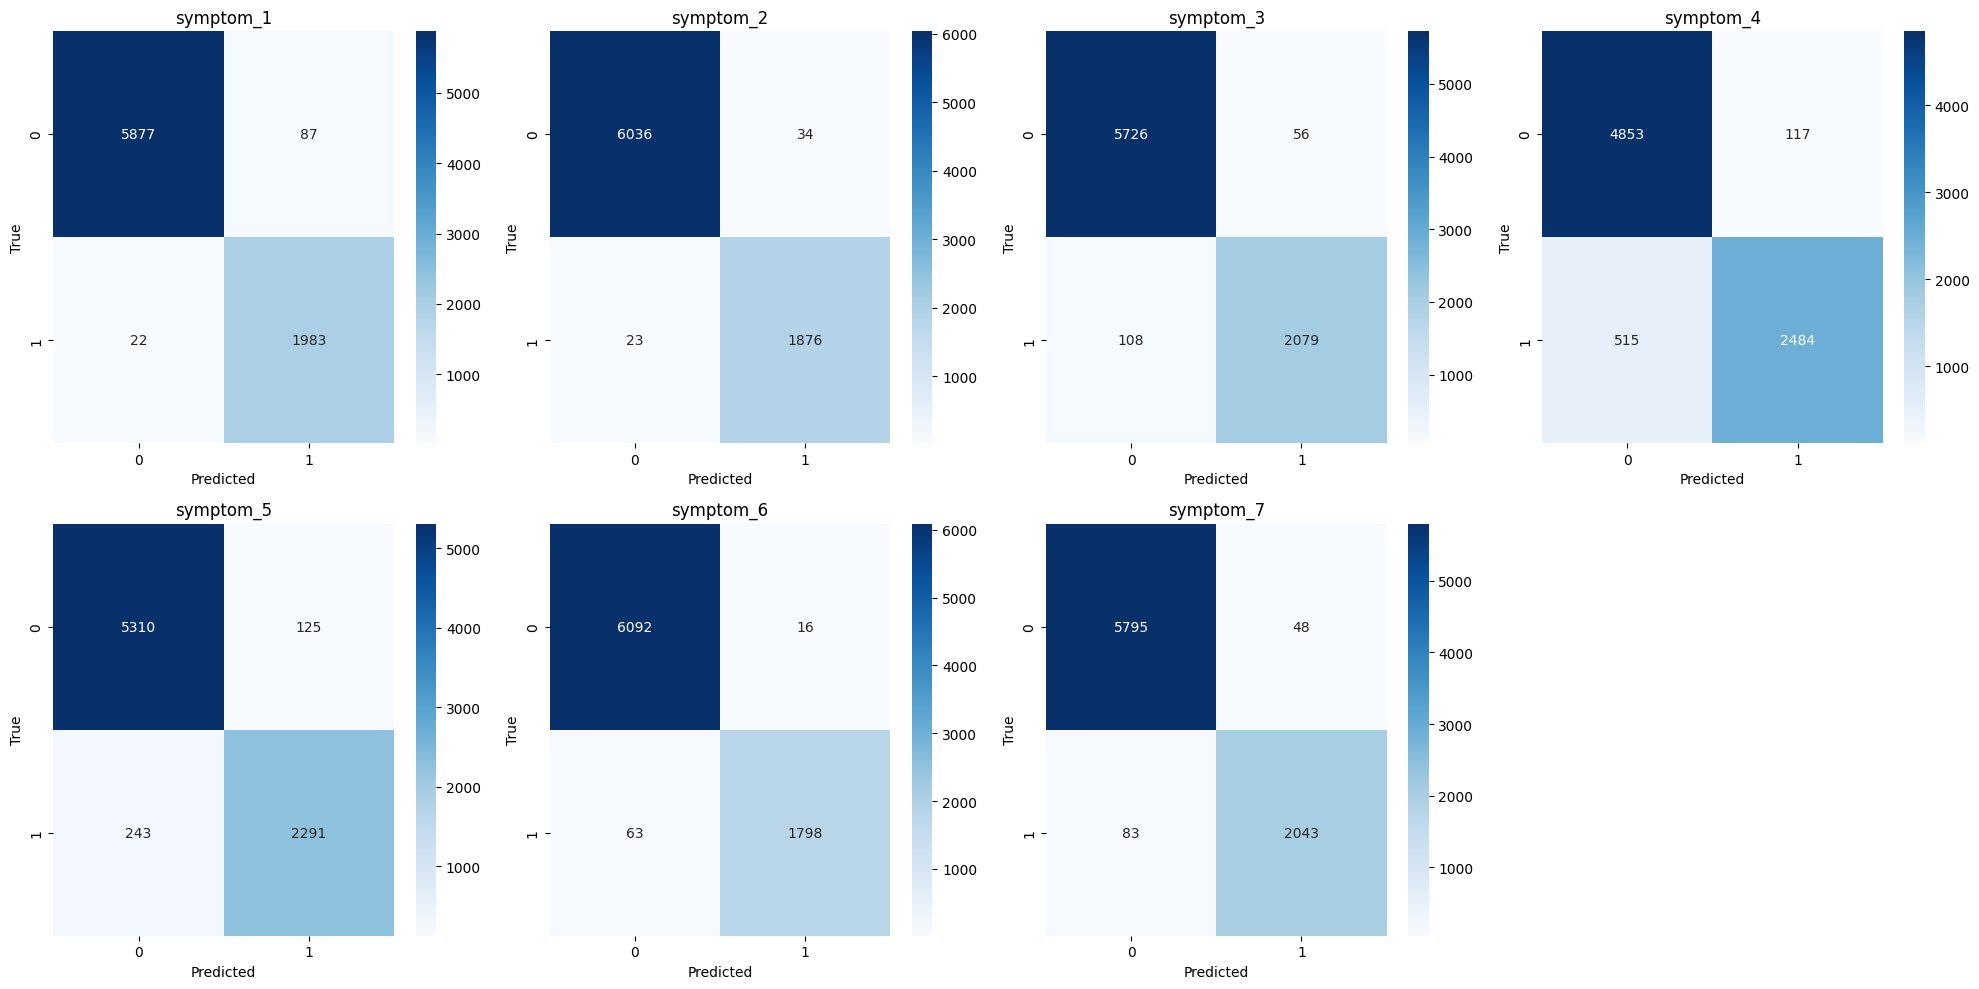

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt


# Calculate the confusion matrix
# Since this is a multi-label classification problem, we'll use multilabel_confusion_matrix
cm = multilabel_confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
# label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']

# Create a grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.delaxes(axes[1, 3])  # remove the last subplot (as we have only 7 labels)

for i, (label_name, ax) in enumerate(zip(label_names, axes.flat)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{label_name}')

plt.tight_layout()
plt.show()

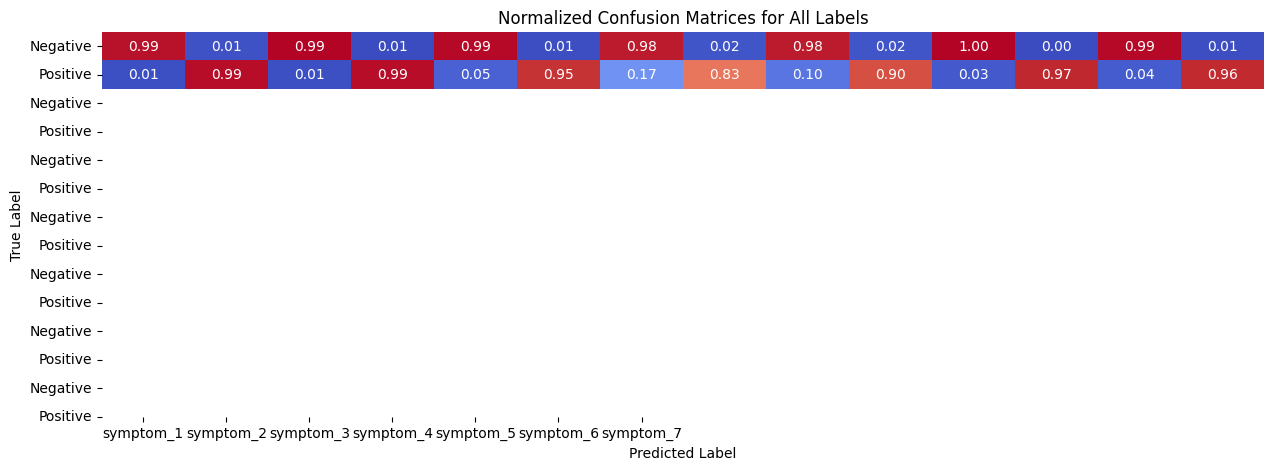

In [10]:
# Create an empty list to store the normalized confusion matrices for each label
confusion_matrices = []

# Calculate the confusion matrices for each label and normalize them
for i in range(7):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    confusion_matrices.append(cm_normalized)

# Combine the normalized confusion matrices into a single array
combined_cm = np.concatenate(confusion_matrices, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(combined_cm, annot=True, cmap="coolwarm", fmt=".2f", cbar=False, xticklabels=label_names, yticklabels=["Negative", "Positive"] * 7)

plt.title("Normalized Confusion Matrices for All Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


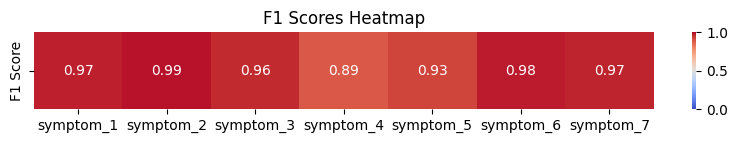

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Extract F1 scores for each label
f1_scores = {label: report[label]['f1-score'] for label in label_names}

# Create a heatmap of F1 scores
f1_scores_matrix = np.array(list(f1_scores.values())).reshape(1, -1)
plt.figure(figsize=(10, 1))
sns.heatmap(f1_scores_matrix, annot=True, fmt='.2f', xticklabels=label_names, yticklabels=['F1 Score'], cmap='coolwarm', vmin=0, vmax=1)
plt.title('F1 Scores Heatmap')
plt.show()


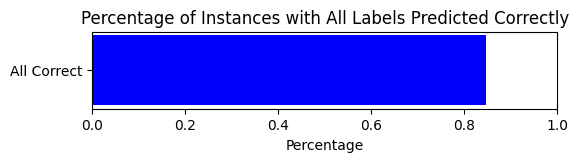

Exact Match Ratio: 0.85


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def all_correct_percentage(y_true, y_pred):
    correct = np.all(y_true == y_pred, axis=1)
    percentage = np.sum(correct) / len(correct)
    return percentage

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the percentage
fig, ax = plt.subplots(figsize=(6, 1))
ax.barh(['All Correct'], [all_correct_pct], color='blue')
ax.set_xlim(0, 1)
ax.set_xlabel('Percentage')
ax.set_title('Percentage of Instances with All Labels Predicted Correctly')
plt.show()

def exact_match_ratio(true_labels, predicted_labels):
    assert true_labels.shape == predicted_labels.shape
    return np.all(true_labels == predicted_labels, axis=1).mean()

exact_match = exact_match_ratio(true_labels, predicted_labels)
print(f"Exact Match Ratio: {exact_match:.2f}")


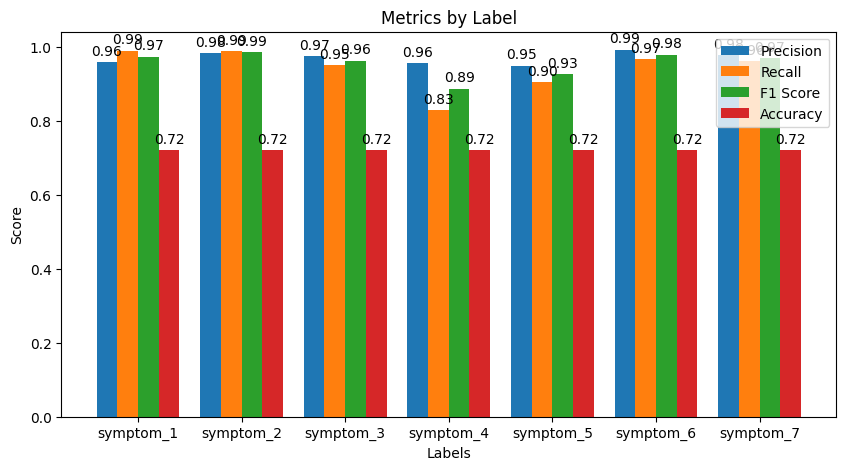

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Extract precision, recall, and F1 score from the classification report
precision = [report[label]['precision'] for label in label_names]
recall = [report[label]['recall'] for label in label_names]
f1_score = [report[label]['f1-score'] for label in label_names]

# Visualize the metrics together
fig, ax = plt.subplots(figsize=(10, 5))
labels = np.arange(len(label_names))
width = 0.2

rects1 = ax.bar(labels - 1.5 * width, precision, width, label='Precision')
rects2 = ax.bar(labels - 0.5 * width, recall, width, label='Recall')
rects3 = ax.bar(labels + 0.5 * width, f1_score, width, label='F1 Score')
rects4 = ax.bar(labels + 1.5 * width, [evaluation_results[1]] * len(labels), width, label='Accuracy')

ax.set_xlabel('Labels')
ax.set_xticks(labels)
ax.set_xticklabels(label_names)
ax.set_ylabel('Score')
ax.set_title('Metrics by Label')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()


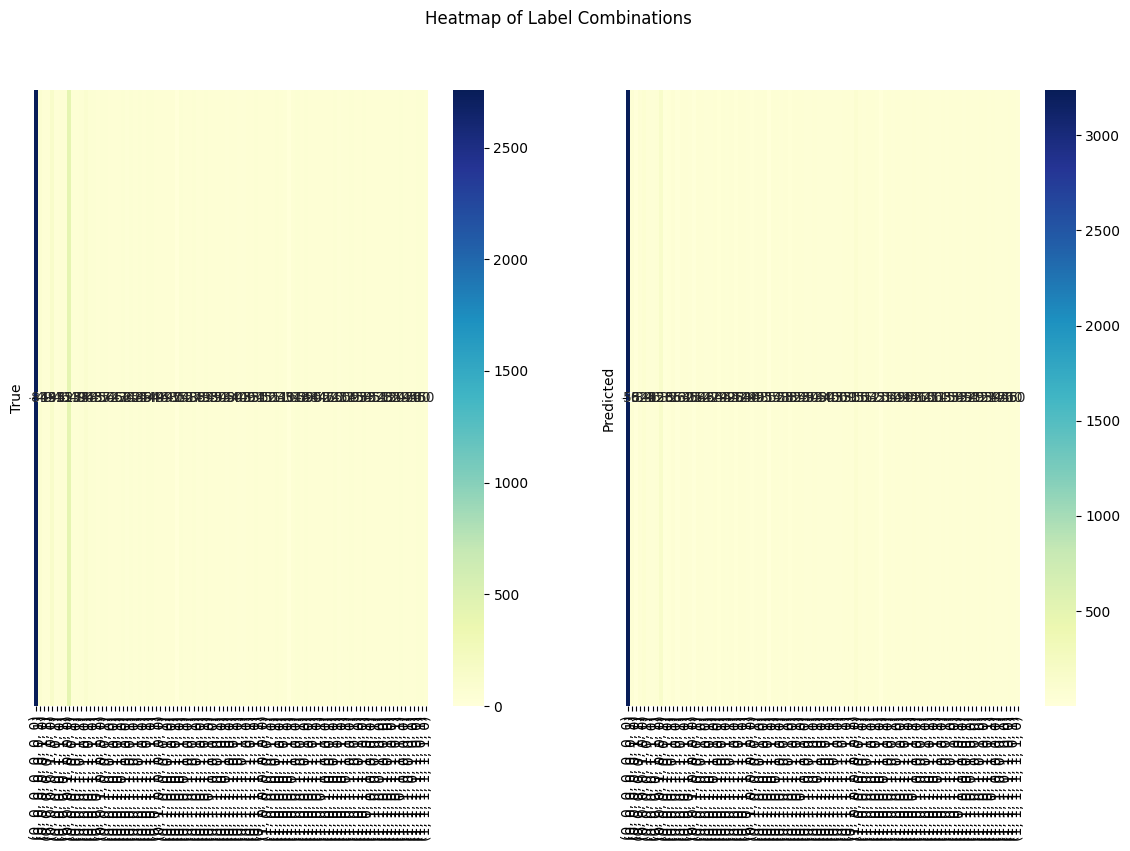

In [14]:
import seaborn as sns
from collections import Counter

def label_combination_counts(labels):
    label_counts = Counter()
    for row in labels:
        label_counts[tuple(row)] += 1
    return label_counts

true_label_counts = label_combination_counts(true_labels)
predicted_label_counts = label_combination_counts(predicted_labels)

label_combinations = sorted(set(list(true_label_counts.keys()) + list(predicted_label_counts.keys())))
true_label_freq = [true_label_counts[combination] for combination in label_combinations]
predicted_label_freq = [predicted_label_counts[combination] for combination in label_combinations]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
fig.suptitle('Heatmap of Label Combinations')

sns.heatmap([true_label_freq], xticklabels=label_combinations, yticklabels=["True"], annot=True, fmt="d", cmap="YlGnBu", ax=ax1)
sns.heatmap([predicted_label_freq], xticklabels=label_combinations, yticklabels=["Predicted"], annot=True, fmt="d", cmap="YlGnBu", ax=ax2)

plt.show()


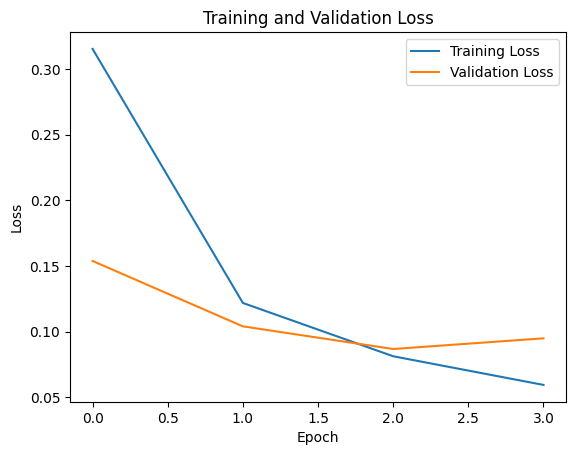

In [15]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

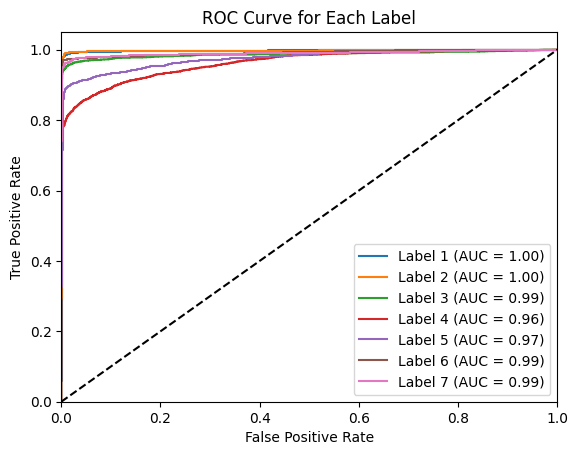

In [16]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC for each label

n_classes = train_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Rest of the code remains the same


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Label {i + 1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc="lower right")
plt.show()

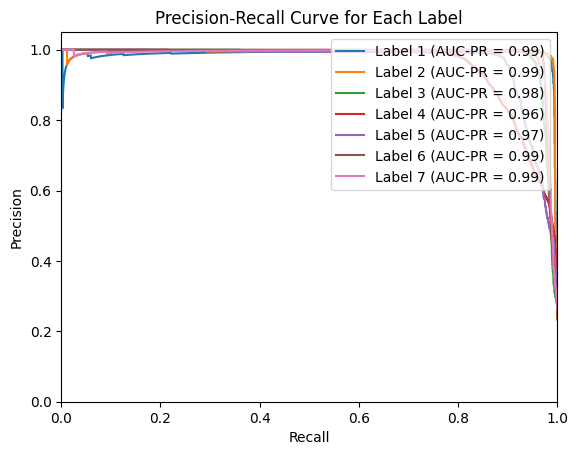

In [17]:
# Calculate Precision-Recall curve and AUC-PR for each label
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels[:, i], logits[:, i])
    average_precision[i] = average_precision_score(true_labels[:, i], logits[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Label {i + 1} (AUC-PR = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc="upper right")
plt.show()

In [18]:
# from transformers import TFBertModel

# # Get the attention weights from BERT
# def get_attention_weights(input_ids, attention_masks):
#     bert = TFBertModel.from_pretrained('bert-base-uncased', output_attentions=True)
#     outputs = bert(input_ids, attention_mask=attention_masks)
#     attentions = outputs.attentions
#     return attentions

# # Analyze the attention weights for a specific sample
# sample_index = 0  # Change this to analyze different samples
# input_id_sample = test_input_ids[sample_index].reshape(1, -1)
# attention_mask_sample = test_attention_masks[sample_index].reshape(1, -1)

# # Convert tensors to the appropriate format
# input_id_sample = tf.convert_to_tensor(input_id_sample)
# attention_mask_sample = tf.convert_to_tensor(attention_mask_sample)

# attentions = get_attention_weights(input_id_sample, attention_mask_sample)

# # Get the words from the input_ids
# tokens = tokenizer.convert_ids_to_tokens(input_id_sample[0])

# # Print the attention weights for the sample
# for i, attention in enumerate(attentions):
#     print(f"Layer {i + 1}")
#     print(tokens)
#     print(attention[0][0].numpy())
#     print("\n")


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


InvalidArgumentError: ignored

In [ ]:

'''qualitative example'''
# Define indices of examples to examine
example_indices = [0, 1, 2, 3, 4, 5, 6]

# Convert the predicted probabilities to binary labels
test_predictions = model.predict([test_input_ids, test_attention_masks])
test_binary_predictions = (np.array(test_predictions.logits, dtype=float) >= 0.5).astype(int)

# Define label names
label_names = ['happiness', 'love', 'enthusiasm', 'fun', 'surprise', 'neutral', 'sadness']

# Choose some examples to examine in more detail
for i in example_indices:
    # Get the input text and true label for the example
    input_text = df['Content'].iloc[test_index[i]]
    true_label = test_labels[i]

    # Get the predicted label for the example
    predicted_label = test_binary_predictions[i]

    # Map the predicted label indices to their names
    predicted_label_names = [label_names[j] for j, label in enumerate(predicted_label) if label == 1]

    # Print the input text, true label, and predicted label
    print("Input text:", input_text)
    print("True label:", true_label)
    print("Predicted label:", predicted_label)

   


250/250 [==============================] - 230s 920ms/step
Input text: shot, like really losing anything, already annoying without anything lol
True label: [0 0 0 0 0 0 0]
Predicted label: [0 0 0 0 0 0 0]
Input text: live sort overthinking thing lot correctly now, spring break extended deuce week maybe even longer cannot handle isolation house, cannot blend in hang friend stupid sleep together virus barely even leave house, around parent really crippling, always make fun weight insult time point lock room never leave unless to, alone long really hard handle, starting overthink lot things. boyfriend want anymore, find someone good, many people could got reason chose really conflicted, really scared friend going get tired dealing me, stress thing time like driving insane cannot even sleep nights, sleep schedule fucked want hug mortal right straight off, tell going okay, really weak sometimes wish reassurance make this, even little bit, even much
True label: [1 1 1 1 1 0 0]
Predicted labe

In [ ]:
# Error analysis
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels



250/250 [==============================] - 230s 919ms/step


In [ ]:
errors = []
for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)):
    if not np.array_equal(pred, true):
        errors.append(i)

print(f"Total errors: {len(errors)}")



# Inspect a specific error
for i in range(1000):
  error_index = errors[i]  # Change this to analyze different errors
  error_df_index = test_index[error_index]  # Get the index in the original dataframe
  print(f"Error {error_index}")
  print("Content: ", df.iloc[error_df_index]['Content'])  # Print the content of the misclassified sample
  print("True labels: ", true_labels[error_index])
  print("Predicted labels: ", predicted_labels[error_index])
  error_content = df.iloc[error_df_index]['Content']
  print(f"Content: {error_content}")


Streaming output truncated to the last 5000 lines.
Error 8
Content:  I Have dealing low point since like feb year I like hah! It cannot get worse last year! I fine!! But day I get lower lower think lowest ever
True labels:  [0 0 1 0 0 0 0]
Predicted labels:  [0 0 0 1 0 0 0]
Content: I Have dealing low point since like feb year I like hah! It cannot get worse last year! I fine!! But day I get lower lower think lowest ever
Error 17
Content:  I anxiety able deal it, becoming breathing problem. I find quite dangerous worrying
True labels:  [0 0 0 0 0 0 0]
Predicted labels:  [0 0 1 0 1 0 0]
Content: I anxiety able deal it, becoming breathing problem. I find quite dangerous worrying
Error 20
Content:  Actually every single relationship I LDR, ik sort thing feel
True labels:  [0 0 0 0 1 0 0]
Predicted labels:  [0 0 0 0 0 0 0]
Content: Actually every single relationship I LDR, ik sort thing feel
Error 28
Content:  I want leave dad place. I feel like could feel better happier stay months. I see

In [26]:
class TFBertModelWithAttention(TFBertModel):
    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        attention = outputs.attentions
        return outputs, attention

# Load the pretrained BERT model
bert_model = TFBertModelWithAttention.from_pretrained('vinai/bertweet-base')

# Get the attention weights for a single input (e.g., the first input in the test set)
input_id = tf.reshape(test_input_ids[0], (1, -1))
attention_mask = tf.reshape(test_attention_masks[0], (1, -1))

# Extract the attention weights
_, attention_weights = bert_model(input_id, attention_mask=attention_mask, output_attentions=True)
attention_weights = np.array([aw.numpy() for aw in attention_weights])

print(attention_weights.shape)

def select_top_heads(attention_weights, num_top_heads, layers_to_consider):
    num_layers, _, num_heads, _, _ = attention_weights.shape
    average_weights = np.mean(attention_weights, axis=(3, 4))

    # Only consider the layers specified in layers_to_consider
    weights_to_consider = average_weights[layers_to_consider, 0, :]
    top_heads_indices = np.argsort(weights_to_consider.ravel())[-num_top_heads:]
    top_heads = [(layers_to_consider[idx // num_heads], idx % num_heads) for idx in top_heads_indices]

    return top_heads

# Example usage:
num_top_heads = 5
layers_to_consider = [0, 11]  # Indices of layers 1 and 12

selected_heads = select_top_heads(attention_weights, num_top_heads, layers_to_consider)
print(selected_heads)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModelWithAttention: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertModelWithAttention from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModelWithAttention from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModelWithAttention were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use 

(12, 1, 12, 387, 387)
[(0, 3), (0, 2), (0, 1), (11, 10), (11, 11)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, yo

BERTweet Attention Visualization for Layer 1, Head 4:
Attention values (Layer 1, Head 4):
[[6.567e-01 2.100e-02 2.260e-02 1.580e-02 7.120e-02 9.600e-03 1.540e-02
  9.180e-02 8.000e-03 2.840e-02 1.050e-02 4.070e-02 8.300e-03]
 [6.433e-01 2.130e-02 2.520e-02 3.060e-02 7.300e-03 3.630e-02 4.990e-02
  1.040e-02 5.130e-02 5.600e-03 1.028e-01 7.900e-03 8.000e-03]
 [6.606e-01 8.300e-03 1.020e-02 1.160e-02 1.226e-01 1.390e-02 5.900e-03
  8.530e-02 3.100e-03 2.530e-02 1.330e-02 3.010e-02 9.900e-03]
 [2.546e-01 2.480e-02 5.160e-02 3.350e-02 1.313e-01 4.600e-03 8.000e-03
  1.171e-01 1.520e-02 2.119e-01 1.040e-02 1.341e-01 2.900e-03]
 [6.340e-01 2.500e-02 1.150e-02 2.870e-02 2.100e-03 4.300e-03 3.400e-02
  1.900e-03 4.500e-03 1.000e-04 5.090e-02 1.300e-03 2.018e-01]
 [5.937e-01 5.890e-02 3.100e-02 1.355e-01 2.500e-03 1.660e-02 3.810e-02
  1.000e-03 8.700e-03 1.000e-04 6.230e-02 4.000e-04 5.110e-02]
 [1.427e-01 1.910e-02 3.450e-02 1.970e-02 1.574e-01 2.510e-02 5.100e-03
  1.387e-01 2.310e-02 3.127e

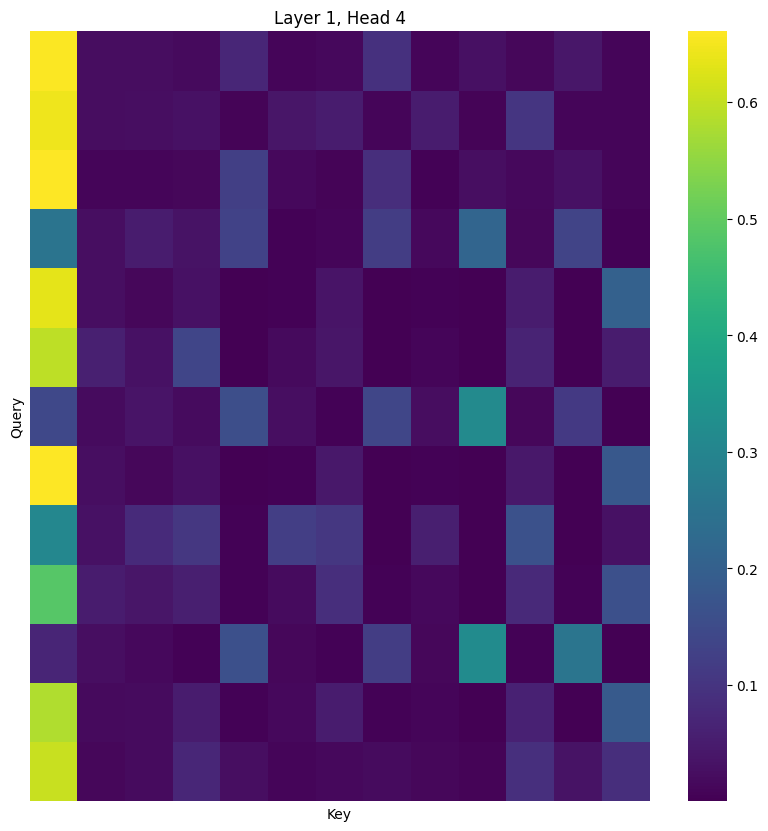

BERTweet Attention Visualization for Layer 1, Head 3:
Attention values (Layer 1, Head 3):
[[0.1673 0.0938 0.0882 0.106  0.0515 0.046  0.0452 0.1119 0.136  0.0252
  0.0324 0.0308 0.0657]
 [0.1326 0.1389 0.0701 0.0347 0.2497 0.0049 0.0093 0.12   0.0257 0.1508
  0.0012 0.0539 0.0082]
 [0.1174 0.4014 0.0246 0.0116 0.0792 0.0169 0.006  0.0757 0.0188 0.0759
  0.0285 0.1046 0.0395]
 [0.2587 0.0805 0.0404 0.0117 0.0719 0.0067 0.0153 0.0873 0.0804 0.1713
  0.0189 0.1419 0.0151]
 [0.1446 0.0733 0.0532 0.0233 0.0888 0.0529 0.0352 0.08   0.027  0.1104
  0.0775 0.1235 0.1102]
 [0.2479 0.1069 0.0547 0.022  0.0506 0.0622 0.0168 0.0706 0.0752 0.0874
  0.0847 0.0638 0.0572]
 [0.192  0.2159 0.0704 0.0911 0.1208 0.0353 0.0187 0.0466 0.0337 0.0554
  0.0371 0.0629 0.02  ]
 [0.145  0.1346 0.1213 0.044  0.1023 0.0525 0.0363 0.0571 0.0146 0.062
  0.0608 0.0906 0.0789]
 [0.101  0.4984 0.1129 0.0445 0.0852 0.01   0.0057 0.0287 0.0145 0.0369
  0.0148 0.0403 0.0071]
 [0.118  0.2827 0.0878 0.0905 0.1225 0.0331 0.0

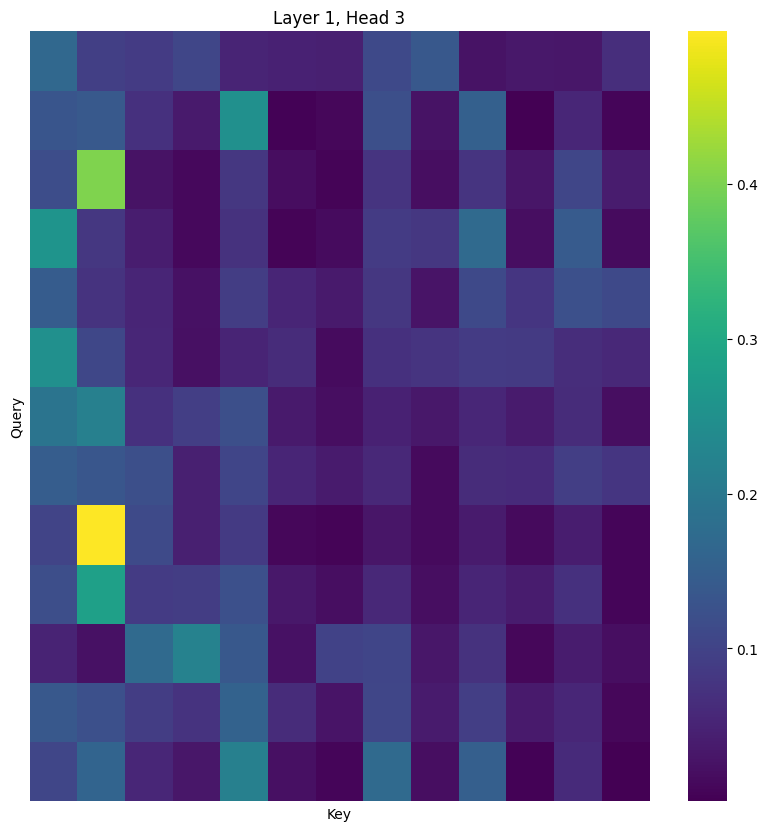

BERTweet Attention Visualization for Layer 1, Head 2:
Attention values (Layer 1, Head 2):
[[8.604e-01 9.800e-03 1.120e-02 6.300e-03 1.370e-02 8.000e-03 1.190e-02
  2.070e-02 7.800e-03 1.850e-02 1.290e-02 1.460e-02 4.100e-03]
 [3.836e-01 1.230e-02 2.150e-02 1.370e-02 1.618e-01 2.430e-02 5.400e-03
  1.639e-01 1.070e-02 6.730e-02 1.900e-03 1.333e-01 2.000e-04]
 [7.794e-01 4.400e-03 2.310e-02 8.000e-03 5.840e-02 9.700e-03 5.800e-03
  3.520e-02 4.100e-03 2.240e-02 1.200e-03 4.830e-02 1.000e-04]
 [4.414e-01 4.790e-02 2.550e-02 4.960e-02 5.170e-02 6.680e-02 1.270e-02
  5.440e-02 6.880e-02 6.150e-02 4.910e-02 7.040e-02 1.000e-04]
 [4.123e-01 4.900e-03 5.100e-03 8.200e-03 1.766e-01 1.820e-02 1.300e-03
  1.191e-01 4.600e-03 7.470e-02 2.900e-03 1.722e-01 1.000e-04]
 [2.144e-01 1.660e-02 1.470e-02 1.880e-02 1.648e-01 2.410e-02 7.300e-03
  1.997e-01 1.510e-02 8.320e-02 5.900e-03 2.315e-01 3.800e-03]
 [7.314e-01 1.400e-02 2.700e-03 1.110e-02 1.290e-02 2.160e-02 1.690e-02
  1.640e-02 5.390e-02 3.600e

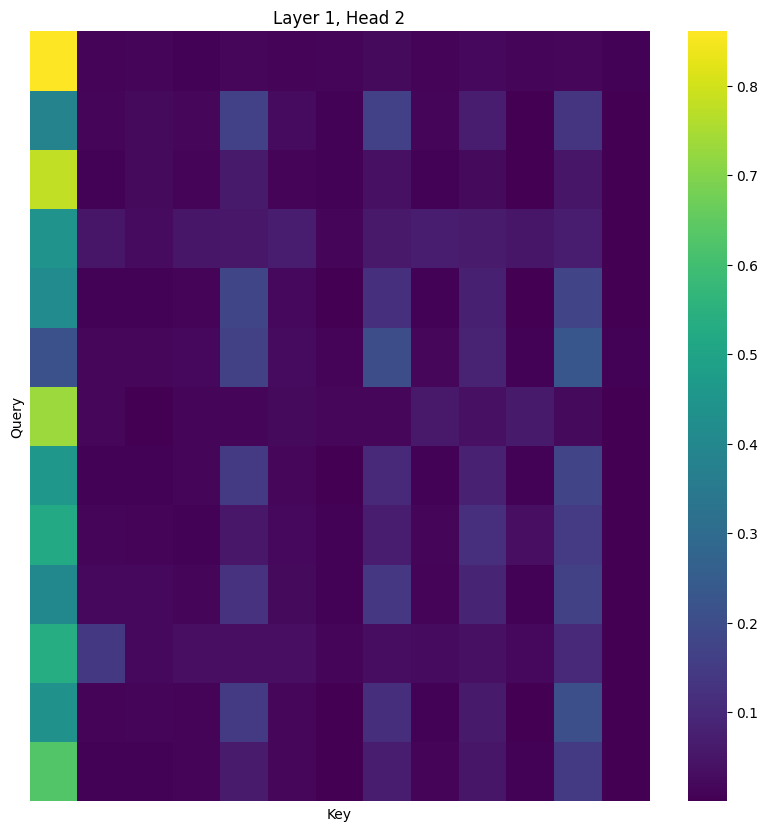

BERTweet Attention Visualization for Layer 12, Head 11:
Attention values (Layer 12, Head 11):
[[4.485e-01 1.870e-02 4.300e-03 3.000e-04 2.900e-03 5.700e-03 1.720e-02
  2.200e-03 1.050e-02 3.200e-03 3.900e-03 9.500e-03 4.731e-01]
 [3.188e-01 2.557e-01 2.010e-02 3.000e-04 5.000e-04 1.440e-02 1.380e-02
  3.000e-04 6.000e-03 6.000e-04 5.000e-04 1.900e-03 3.671e-01]
 [4.116e-01 2.020e-02 1.265e-01 1.000e-04 3.000e-04 4.000e-04 1.600e-03
  2.000e-04 1.000e-04 2.000e-04 3.000e-04 2.300e-03 4.362e-01]
 [4.341e-01 3.900e-03 2.500e-03 5.000e-04 8.000e-04 6.000e-04 7.700e-03
  2.000e-04 5.000e-04 1.800e-03 1.200e-03 6.600e-03 5.393e-01]
 [3.716e-01 6.050e-02 2.250e-02 1.500e-03 1.640e-02 1.360e-02 2.310e-02
  8.400e-03 6.400e-03 3.100e-03 1.820e-02 3.440e-02 4.204e-01]
 [3.127e-01 1.540e-01 9.400e-03 3.000e-04 2.900e-03 6.930e-02 4.320e-02
  1.700e-03 2.190e-02 4.500e-03 5.300e-03 8.100e-03 3.666e-01]
 [3.860e-01 2.880e-02 1.900e-03 1.000e-03 2.900e-03 5.200e-03 4.020e-02
  1.500e-03 2.050e-02 2.

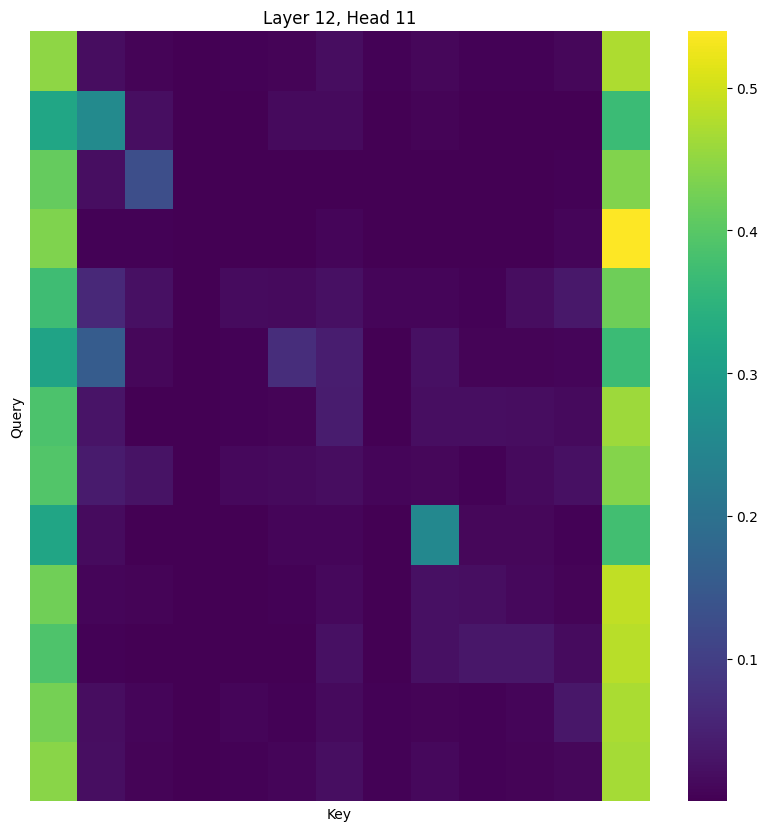

BERTweet Attention Visualization for Layer 12, Head 12:
Attention values (Layer 12, Head 12):
[[4.517e-01 1.290e-02 2.000e-03 1.100e-03 3.700e-03 3.500e-03 1.100e-03
  3.200e-03 2.300e-03 6.600e-03 6.000e-04 1.560e-02 4.956e-01]
 [4.017e-01 3.730e-02 3.300e-03 1.000e-04 4.800e-03 1.480e-02 1.700e-03
  4.100e-03 6.400e-03 9.900e-03 3.000e-04 1.160e-02 5.039e-01]
 [2.156e-01 1.529e-01 1.195e-01 1.000e-04 1.020e-02 2.070e-02 3.000e-03
  6.900e-03 8.000e-03 3.530e-02 4.000e-04 1.444e-01 2.829e-01]
 [2.446e-01 8.850e-02 2.060e-02 7.200e-03 2.430e-02 5.550e-02 7.430e-02
  1.650e-02 2.550e-02 4.850e-02 5.280e-02 4.680e-02 2.948e-01]
 [4.120e-01 1.420e-02 5.400e-03 1.000e-04 4.900e-03 4.900e-03 7.000e-04
  5.000e-03 1.900e-03 2.500e-03 2.000e-04 1.460e-02 5.337e-01]
 [4.072e-01 2.080e-02 1.700e-03 1.000e-04 4.400e-03 1.480e-02 1.400e-03
  3.800e-03 5.500e-03 7.700e-03 1.000e-04 1.870e-02 5.138e-01]
 [1.060e-01 1.591e-01 5.700e-03 7.600e-03 2.830e-02 8.340e-02 1.233e-01
  1.930e-02 7.890e-02 1.

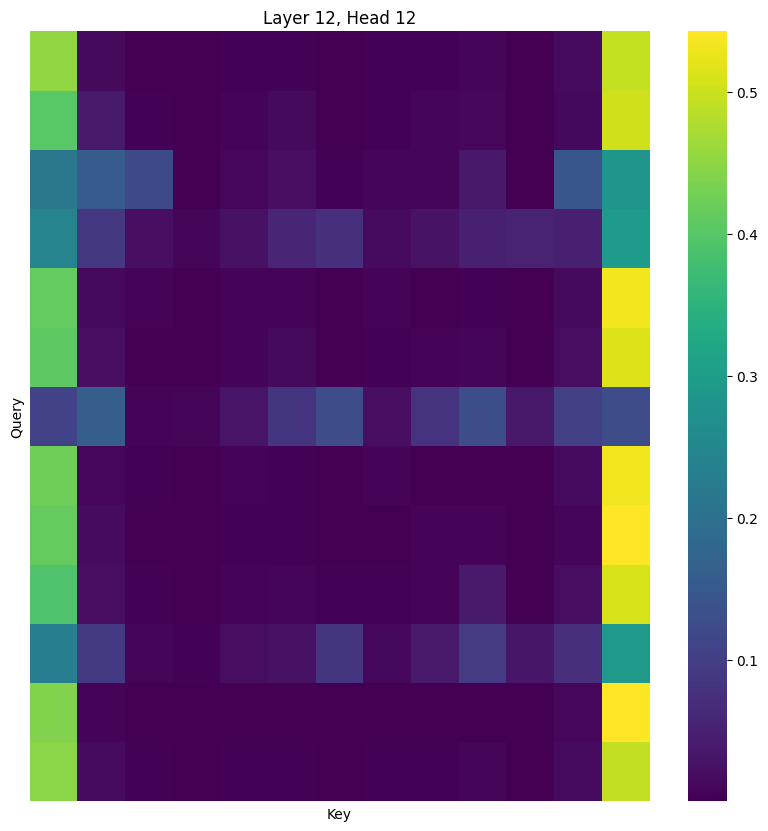

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
bertweet_model = TFAutoModel.from_pretrained('vinai/bertweet-base')

# sample_sentence = "Can't sleep, always tired, hard to focus."
sample_sentence = "Lost appetite, feel guilty, thinking of ending it."

bertweet_tokens = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_tensors="tf")
bertweet_outputs = bertweet_model(bertweet_tokens['input_ids'], attention_mask=bertweet_tokens['attention_mask'], output_attentions=True)
bertweet_attention = bertweet_outputs.attentions

def plot_attention(tokens, attention, layer, head):
    plt.figure(figsize=(10, 10))
    tokens = tokenizer.convert_ids_to_tokens(tokens.numpy()[0])
    attention_values = attention[layer][0, head].numpy()
    print(f"Attention values (Layer {layer + 1}, Head {head + 1}):")
    print(np.round(attention_values, decimals=4))
    ax = sns.heatmap(attention_values, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    ax.xaxis.tick_top()
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(f"Layer {layer + 1}, Head {head + 1}")
    plt.show()

selected_heads = [(0, 3), (0, 2), (0, 1), (11, 10), (11, 11)]

for layer, head in selected_heads:
  print(f"BERTweet Attention Visualization for Layer {layer + 1}, Head {head + 1}:")
  plot_attention(bertweet_tokens['input_ids'], bertweet_attention, layer, head)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, yo

BERTweet Attention Visualization for Layer 1, Head 4:
Attention values (Layer 1, Head 4):
[[6.567e-01 2.100e-02 2.260e-02 1.580e-02 7.120e-02 9.600e-03 1.540e-02
  9.180e-02 8.000e-03 2.840e-02 1.050e-02 4.070e-02 8.300e-03]
 [6.433e-01 2.130e-02 2.520e-02 3.060e-02 7.300e-03 3.630e-02 4.990e-02
  1.040e-02 5.130e-02 5.600e-03 1.028e-01 7.900e-03 8.000e-03]
 [6.606e-01 8.300e-03 1.020e-02 1.160e-02 1.226e-01 1.390e-02 5.900e-03
  8.530e-02 3.100e-03 2.530e-02 1.330e-02 3.010e-02 9.900e-03]
 [2.546e-01 2.480e-02 5.160e-02 3.350e-02 1.313e-01 4.600e-03 8.000e-03
  1.171e-01 1.520e-02 2.119e-01 1.040e-02 1.341e-01 2.900e-03]
 [6.340e-01 2.500e-02 1.150e-02 2.870e-02 2.100e-03 4.300e-03 3.400e-02
  1.900e-03 4.500e-03 1.000e-04 5.090e-02 1.300e-03 2.018e-01]
 [5.937e-01 5.890e-02 3.100e-02 1.355e-01 2.500e-03 1.660e-02 3.810e-02
  1.000e-03 8.700e-03 1.000e-04 6.230e-02 4.000e-04 5.110e-02]
 [1.427e-01 1.910e-02 3.450e-02 1.970e-02 1.574e-01 2.510e-02 5.100e-03
  1.387e-01 2.310e-02 3.127e

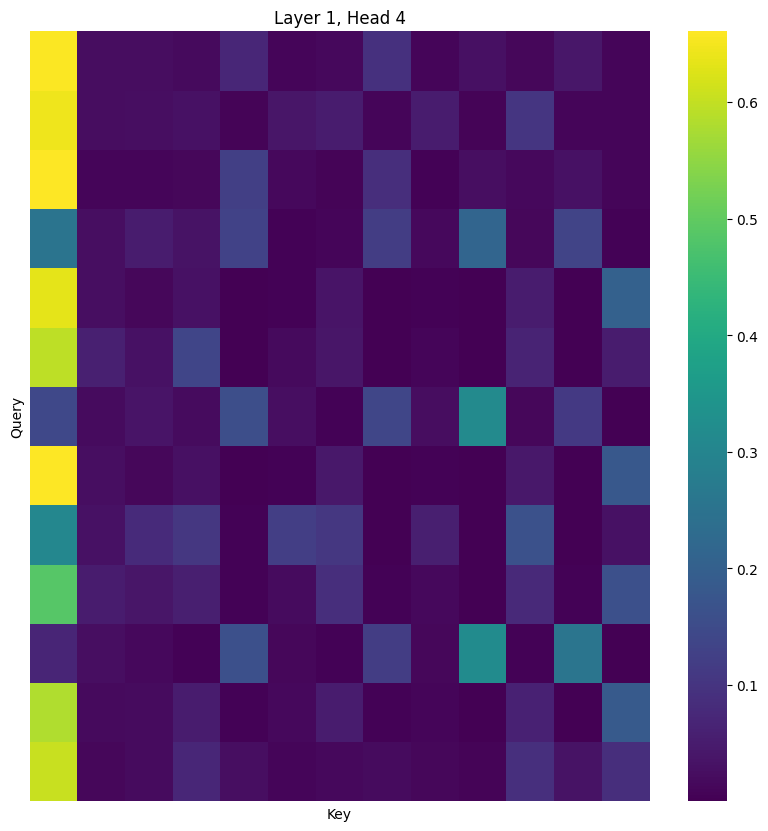

BERTweet Attention Visualization for Layer 1, Head 3:
Attention values (Layer 1, Head 3):
[[0.1673 0.0938 0.0882 0.106  0.0515 0.046  0.0452 0.1119 0.136  0.0252
  0.0324 0.0308 0.0657]
 [0.1326 0.1389 0.0701 0.0347 0.2497 0.0049 0.0093 0.12   0.0257 0.1508
  0.0012 0.0539 0.0082]
 [0.1174 0.4014 0.0246 0.0116 0.0792 0.0169 0.006  0.0757 0.0188 0.0759
  0.0285 0.1046 0.0395]
 [0.2587 0.0805 0.0404 0.0117 0.0719 0.0067 0.0153 0.0873 0.0804 0.1713
  0.0189 0.1419 0.0151]
 [0.1446 0.0733 0.0532 0.0233 0.0888 0.0529 0.0352 0.08   0.027  0.1104
  0.0775 0.1235 0.1102]
 [0.2479 0.1069 0.0547 0.022  0.0506 0.0622 0.0168 0.0706 0.0752 0.0874
  0.0847 0.0638 0.0572]
 [0.192  0.2159 0.0704 0.0911 0.1208 0.0353 0.0187 0.0466 0.0337 0.0554
  0.0371 0.0629 0.02  ]
 [0.145  0.1346 0.1213 0.044  0.1023 0.0525 0.0363 0.0571 0.0146 0.062
  0.0608 0.0906 0.0789]
 [0.101  0.4984 0.1129 0.0445 0.0852 0.01   0.0057 0.0287 0.0145 0.0369
  0.0148 0.0403 0.0071]
 [0.118  0.2827 0.0878 0.0905 0.1225 0.0331 0.0

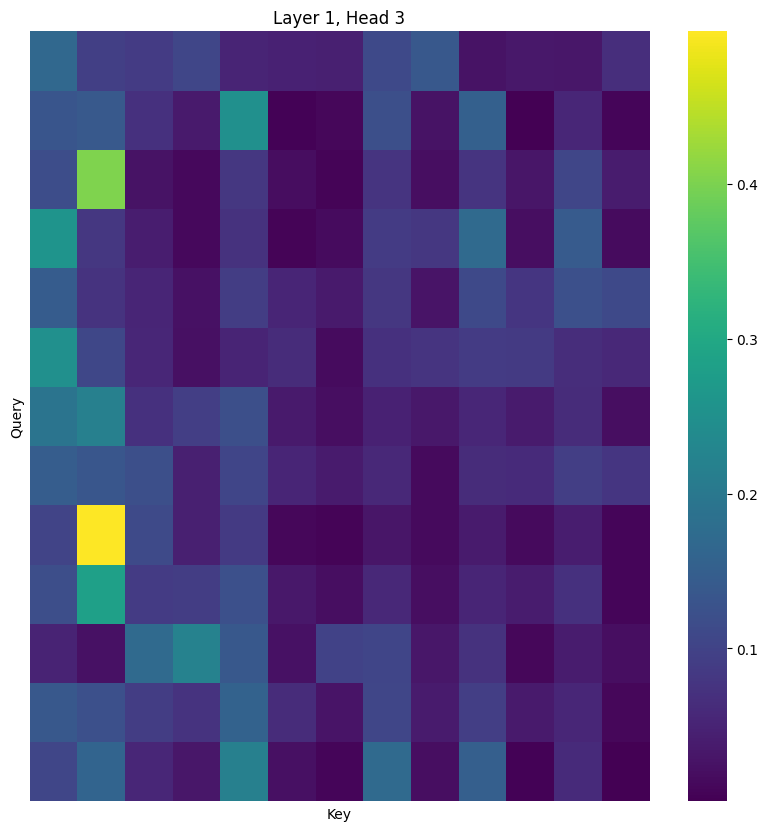

BERTweet Attention Visualization for Layer 1, Head 2:
Attention values (Layer 1, Head 2):
[[8.604e-01 9.800e-03 1.120e-02 6.300e-03 1.370e-02 8.000e-03 1.190e-02
  2.070e-02 7.800e-03 1.850e-02 1.290e-02 1.460e-02 4.100e-03]
 [3.836e-01 1.230e-02 2.150e-02 1.370e-02 1.618e-01 2.430e-02 5.400e-03
  1.639e-01 1.070e-02 6.730e-02 1.900e-03 1.333e-01 2.000e-04]
 [7.794e-01 4.400e-03 2.310e-02 8.000e-03 5.840e-02 9.700e-03 5.800e-03
  3.520e-02 4.100e-03 2.240e-02 1.200e-03 4.830e-02 1.000e-04]
 [4.414e-01 4.790e-02 2.550e-02 4.960e-02 5.170e-02 6.680e-02 1.270e-02
  5.440e-02 6.880e-02 6.150e-02 4.910e-02 7.040e-02 1.000e-04]
 [4.123e-01 4.900e-03 5.100e-03 8.200e-03 1.766e-01 1.820e-02 1.300e-03
  1.191e-01 4.600e-03 7.470e-02 2.900e-03 1.722e-01 1.000e-04]
 [2.144e-01 1.660e-02 1.470e-02 1.880e-02 1.648e-01 2.410e-02 7.300e-03
  1.997e-01 1.510e-02 8.320e-02 5.900e-03 2.315e-01 3.800e-03]
 [7.314e-01 1.400e-02 2.700e-03 1.110e-02 1.290e-02 2.160e-02 1.690e-02
  1.640e-02 5.390e-02 3.600e

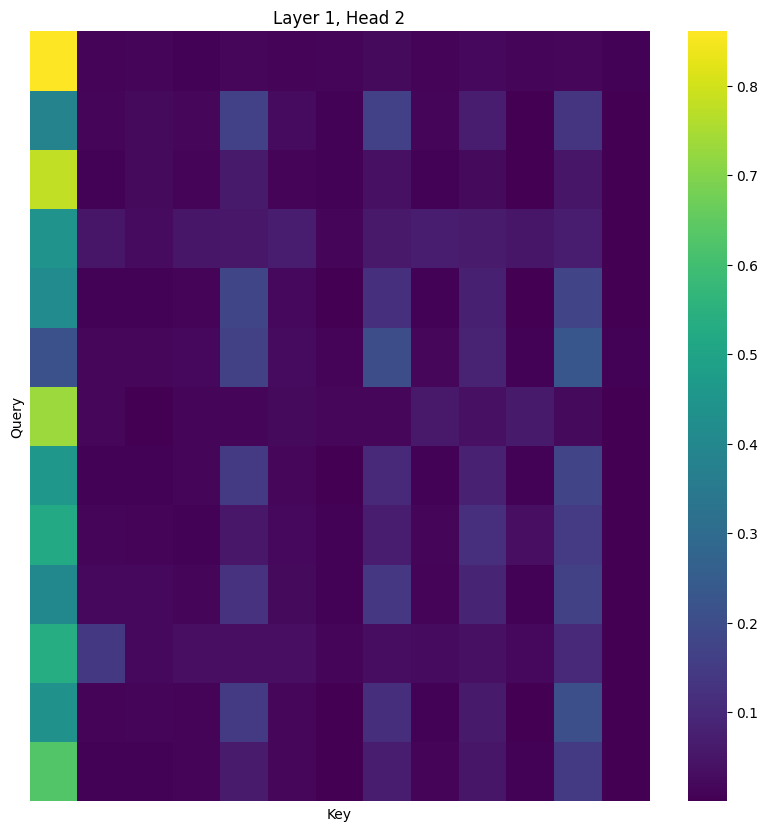

BERTweet Attention Visualization for Layer 12, Head 11:
Attention values (Layer 12, Head 11):
[[4.485e-01 1.870e-02 4.300e-03 3.000e-04 2.900e-03 5.700e-03 1.720e-02
  2.200e-03 1.050e-02 3.200e-03 3.900e-03 9.500e-03 4.731e-01]
 [3.188e-01 2.557e-01 2.010e-02 3.000e-04 5.000e-04 1.440e-02 1.380e-02
  3.000e-04 6.000e-03 6.000e-04 5.000e-04 1.900e-03 3.671e-01]
 [4.116e-01 2.020e-02 1.265e-01 1.000e-04 3.000e-04 4.000e-04 1.600e-03
  2.000e-04 1.000e-04 2.000e-04 3.000e-04 2.300e-03 4.362e-01]
 [4.341e-01 3.900e-03 2.500e-03 5.000e-04 8.000e-04 6.000e-04 7.700e-03
  2.000e-04 5.000e-04 1.800e-03 1.200e-03 6.600e-03 5.393e-01]
 [3.716e-01 6.050e-02 2.250e-02 1.500e-03 1.640e-02 1.360e-02 2.310e-02
  8.400e-03 6.400e-03 3.100e-03 1.820e-02 3.440e-02 4.204e-01]
 [3.127e-01 1.540e-01 9.400e-03 3.000e-04 2.900e-03 6.930e-02 4.320e-02
  1.700e-03 2.190e-02 4.500e-03 5.300e-03 8.100e-03 3.666e-01]
 [3.860e-01 2.880e-02 1.900e-03 1.000e-03 2.900e-03 5.200e-03 4.020e-02
  1.500e-03 2.050e-02 2.

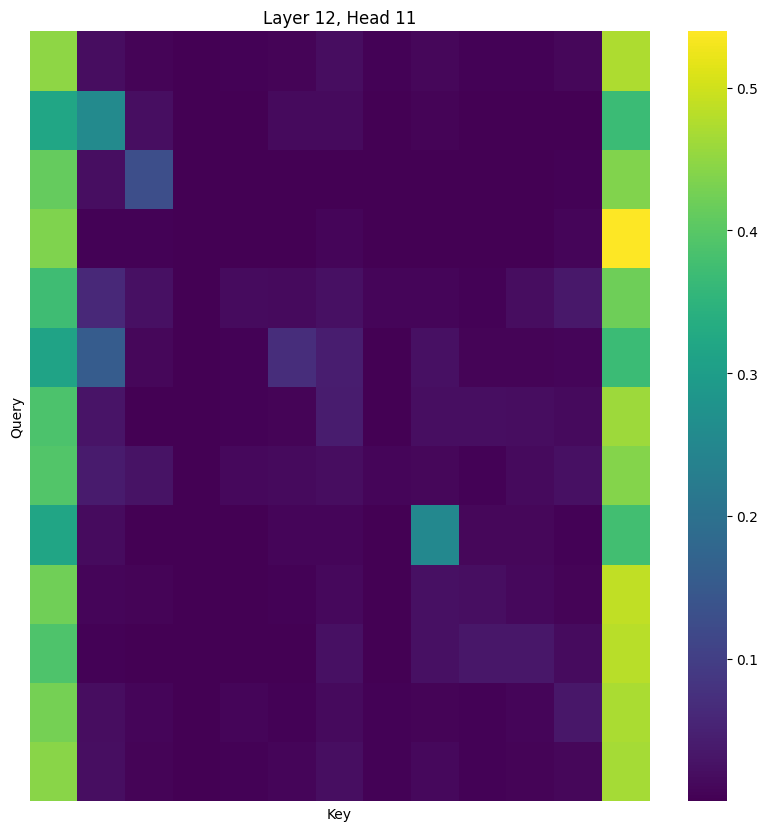

BERTweet Attention Visualization for Layer 12, Head 12:
Attention values (Layer 12, Head 12):
[[4.517e-01 1.290e-02 2.000e-03 1.100e-03 3.700e-03 3.500e-03 1.100e-03
  3.200e-03 2.300e-03 6.600e-03 6.000e-04 1.560e-02 4.956e-01]
 [4.017e-01 3.730e-02 3.300e-03 1.000e-04 4.800e-03 1.480e-02 1.700e-03
  4.100e-03 6.400e-03 9.900e-03 3.000e-04 1.160e-02 5.039e-01]
 [2.156e-01 1.529e-01 1.195e-01 1.000e-04 1.020e-02 2.070e-02 3.000e-03
  6.900e-03 8.000e-03 3.530e-02 4.000e-04 1.444e-01 2.829e-01]
 [2.446e-01 8.850e-02 2.060e-02 7.200e-03 2.430e-02 5.550e-02 7.430e-02
  1.650e-02 2.550e-02 4.850e-02 5.280e-02 4.680e-02 2.948e-01]
 [4.120e-01 1.420e-02 5.400e-03 1.000e-04 4.900e-03 4.900e-03 7.000e-04
  5.000e-03 1.900e-03 2.500e-03 2.000e-04 1.460e-02 5.337e-01]
 [4.072e-01 2.080e-02 1.700e-03 1.000e-04 4.400e-03 1.480e-02 1.400e-03
  3.800e-03 5.500e-03 7.700e-03 1.000e-04 1.870e-02 5.138e-01]
 [1.060e-01 1.591e-01 5.700e-03 7.600e-03 2.830e-02 8.340e-02 1.233e-01
  1.930e-02 7.890e-02 1.

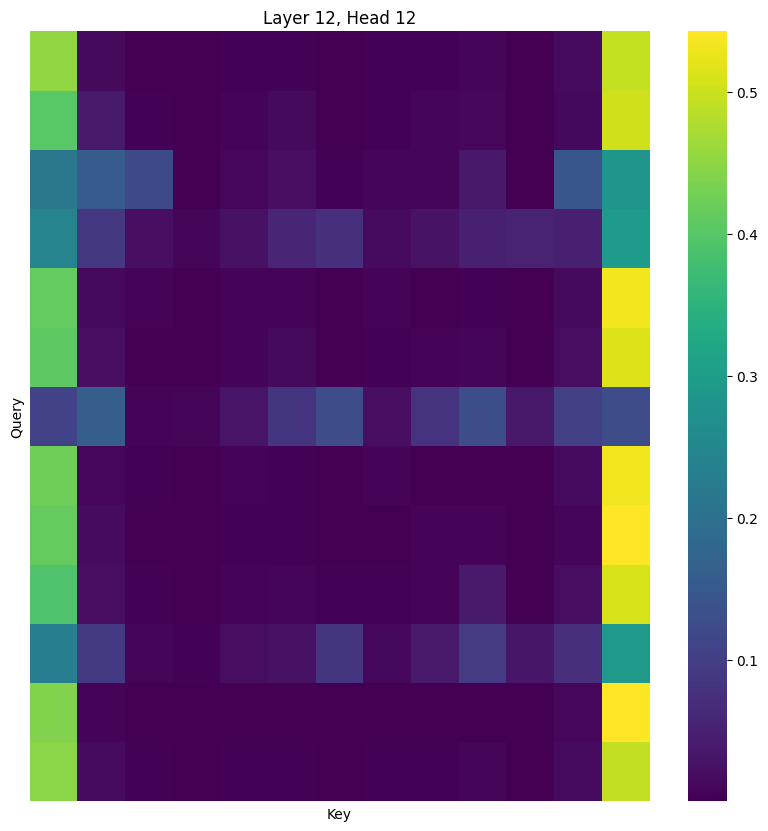

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
bertweet_model = TFAutoModel.from_pretrained('vinai/bertweet-base')

sample_sentence = "Can't sleep, always tired, hard to focus."
# sample_sentence = "Lost appetite, feel guilty, thinking of ending it."

bertweet_tokens = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_tensors="tf")
bertweet_outputs = bertweet_model(bertweet_tokens['input_ids'], attention_mask=bertweet_tokens['attention_mask'], output_attentions=True)
bertweet_attention = bertweet_outputs.attentions

def plot_attention(tokens, attention, layer, head):
    plt.figure(figsize=(10, 10))
    tokens = tokenizer.convert_ids_to_tokens(tokens.numpy()[0])
    attention_values = attention[layer][0, head].numpy()
    print(f"Attention values (Layer {layer + 1}, Head {head + 1}):")
    print(np.round(attention_values, decimals=4))
    ax = sns.heatmap(attention_values, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    ax.xaxis.tick_top()
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(f"Layer {layer + 1}, Head {head + 1}")
    plt.show()

selected_heads = [(0, 3), (0, 2), (0, 1), (11, 10), (11, 11)]

for layer, head in selected_heads:
  print(f"BERTweet Attention Visualization for Layer {layer + 1}, Head {head + 1}:")
  plot_attention(bertweet_tokens['input_ids'], bertweet_attention, layer, head)
